### Objective: retrieve the words corresponding to a state change as embeddings to see if they share some common features

In [22]:
# --- Step 1: Load and print color transitions ---
import pickle
import numpy as np
import os
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Add src directory to Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import MODEL_NAME

# Load the log
with open("data/clustering/color_transitions_log.pkl", "rb") as f:
    color_log = pickle.load(f)

print(f"Loaded {len(color_log)} samples\n")

# --- Print a few sample entries ---
NUM_TO_PRINT = 5

for i, entry in enumerate(color_log[:NUM_TO_PRINT]):
    print(f"Sample {i + 1}")
    print("Tokens:", ' '.join(entry["tokens"]))
    print("Transitions:", entry["transitions"])
    print("States:", entry["states"])
    print("-" * 50)

Loaded 20 samples

Sample 1
Tokens: [CLS] i love sci - fi and am willing to put up with a lot . sci - fi movies / tv are usually under ##fu ##nded , under - appreciated and misunderstood . i tried to like this , i really did , but it is to good tv sci - fi as babylon 5 is to star trek ( the original ) . silly pro ##st ##hetic ##s , cheap cardboard sets , stil ##ted dialogues , c ##g that doesn ' t match the background , and painfully one - dimensional characters cannot be overcome with a
Transitions: [(0, 1), (1, 5), (5, 35), (35, 44), (44, 65), (65, 85), (85, 100)]
States: [np.int64(1), np.int64(3), np.int64(2), np.int64(3), np.int64(2), np.int64(3), np.int64(0)]
--------------------------------------------------
Sample 2
Tokens: [CLS] worth the entertainment value of a rental , especially if you like action movies . this one features the usual car chases , fights with the great van dam ##me kick style , shooting battles with the 40 shell load shotgun , and even terrorist style bombs 

In [23]:
# At each transition index, get the token at that index
transition_tokens = []

for entry in color_log:
    tokens = entry["tokens"]
    transitions = entry["transitions"]  # e.g. [(0,3), (3,6), (6,8)]

    # transitions is a list of (start, end) ranges
    # we care about the *start index* of each segment after the first
    for start_idx, _ in transitions[1:]:  # skip the first
        if start_idx < len(tokens):
            transition_tokens.append(tokens[start_idx])


In [24]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pretrained model (any good BERT variant)
model_name = MODEL_NAME
tok = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)
bert.eval()

# Deduplicate words and get their embeddings
unique_tokens = list(set(transition_tokens))
print(f"Unique transition tokens: {len(unique_tokens)}")

def embed_token(token):
    with torch.no_grad():
        inputs = tok(token, return_tensors="pt")
        outputs = bert(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        return cls_embedding.squeeze().numpy()

embedding_matrix = np.array([embed_token(tok) for tok in unique_tokens])


Unique transition tokens: 47


In [25]:
import plotly.express as pxa
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.io as pio

# Try these one at a time depending on your setup
# Best for Jupyter Lab / VSCode
pio.renderers.default = "iframe_connected"

# K-Means clustering

In [26]:
# --- Clustering ---
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embedding_matrix)

# --- Dimensionality reduction ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embedding_matrix)

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_sum = explained_variance_ratio.sum()

# Print explained variance information
print(f"Explained variance by Component 1: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]*100:.2f}%)")
print(f"Explained variance by Component 2: {explained_variance_ratio[1]:.4f} ({explained_variance_ratio[1]*100:.2f}%)")
print(f"Total explained variance by plotted components: {explained_variance_sum:.4f} ({explained_variance_sum*100:.2f}%)")

# --- Prepare DataFrame for Plotly ---
df = pd.DataFrame({
    "Token": unique_tokens,
    "Cluster": labels,
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
})

# --- Interactive plot ---
fig = pxa.scatter(
    df,
    x="PCA1",
    y="PCA2",
    color="Cluster",
    hover_data=["Token"],
    title="K-Means Clustering of Transition Tokens (BERT Embeddings)",
    labels={"PCA1": "Component 1", "PCA2": "Component 2"}
)

fig.update_traces(marker=dict(size=6), selector=dict(mode='markers'))
fig.update_layout(showlegend=True)
fig.show()
fig.write_html("KMEANS.html")


Explained variance by Component 1: 0.3762 (37.62%)
Explained variance by Component 2: 0.2170 (21.70%)
Total explained variance by plotted components: 0.5932 (59.32%)


# UMAP

In [27]:
! pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
import umap
import plotly.express as px

# --- UMAP for dimensionality reduction ---
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
X_umap = umap_model.fit_transform(embedding_matrix)

# --- Reuse clustering labels (from KMeans or hierarchical) ---
df_umap = pd.DataFrame({
    "Token": unique_tokens,
    "Cluster": labels,  # reuse or replace with new clustering results
    "UMAP1": X_umap[:, 0],
    "UMAP2": X_umap[:, 1],
})

# --- Plot with Plotly ---
fig = px.scatter(
    df_umap,
    x="UMAP1",
    y="UMAP2",
    color=df_umap["Cluster"].astype(str),
    hover_name="Token",
    title="UMAP Projection of Transition Tokens",
    labels={"UMAP1": "UMAP-1", "UMAP2": "UMAP-2"}
)
fig.update_traces(marker=dict(size=7, opacity=0.8))
fig.update_layout(margin=dict(l=20, r=20, t=40, b=20), hovermode='closest')
fig.show()


/home/giovanni/miniconda3/envs/pmlproj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/giovanni/miniconda3/envs/pmlproj/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Hierarchical clustering

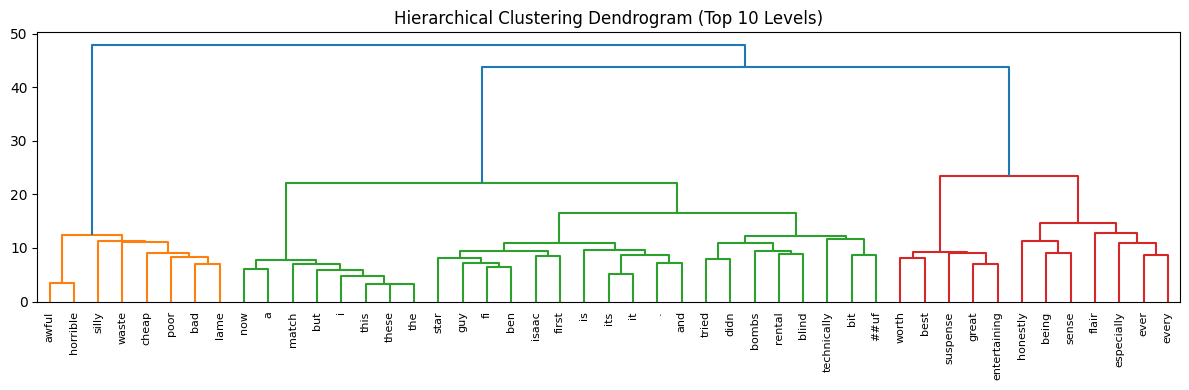

/home/giovanni/miniconda3/envs/pmlproj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/giovanni/miniconda3/envs/pmlproj/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [29]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import normalize

# --- Compute linkage matrix ---
Z = linkage(embedding_matrix, method='ward')  # or try 'average', 'complete', 'single'

# --- Decide on number of clusters ---
n_clusters_h = 4
labels_hierarchical = fcluster(Z, t=n_clusters_h, criterion='maxclust')

# Optional: plot dendrogram (can be slow for many points)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
dendrogram(Z, truncate_mode='level', p=10, labels=unique_tokens)
plt.title("Hierarchical Clustering Dendrogram (Top 10 Levels)")
plt.tight_layout()
plt.show()

# --- Use UMAP for 2D layout ---
X_umap_h = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42).fit_transform(embedding_matrix)

# --- Plot interactive clusters ---
df_hier = pd.DataFrame({
    "Token": unique_tokens,
    "Cluster": labels_hierarchical,
    "UMAP1": X_umap_h[:, 0],
    "UMAP2": X_umap_h[:, 1],
})

fig = px.scatter(
    df_hier,
    x="UMAP1",
    y="UMAP2",
    color=df_hier["Cluster"].astype(str),
    hover_name="Token",
    title="Hierarchical Clustering (UMAP layout)",
    labels={"UMAP1": "UMAP-1", "UMAP2": "UMAP-2"}
)
fig.update_traces(marker=dict(size=7, opacity=0.8))
fig.update_layout(margin=dict(l=20, r=20, t=40, b=20), hovermode='closest')
fig.show()


Description: there seem to be 2 distinct clusters at least, one with adjectives and one with adverbs. These are grouped together by hierarchical clustering. 